In [1]:
from pathlib import Path
from collections import namedtuple
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sliding1d as sliding

import datareader as dr
import saccades as sc
import trial_envelope as envelope
import ROC

In [2]:
trials  = dr.load_trials("../01_data/04_formatted")

# representative session
subject = "MLA007518"
session = "session2019-09-30-001"

in_session = [trial for trial in trials if (trial.subject == subject and trial.session == session)]

In [3]:
figroot = Path("../05_figures/prediction/ROC")
saved   = False

labelsize = 12

def savefig(fig, basepath, root=None, dpi=600, as_png=True, as_svg=True):
    if saved == False:
        return
    if root is None:
        root = figroot
    base = root / Path(basepath)
    if not base.parent.exists():
        base.parent.mkdir(parents=True)
    is_saved = False
    if as_png == True:
        fig.savefig(str(base) + ".png", dpi=dpi)
        is_saved = True
    if as_svg == True:
        fig.savefig(str(base) + ".svg")
        is_saved = True
    if saved == True:
        print(f"--> saved to: {base}")
    else:
        print(f"--> ***not saved: {base}")

def psign(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ", NS"

## Extraction of set points

In [4]:
# def interpolate(vec, min_size=10):
#     valid = ~np.isnan(vec)
#     if np.count_nonzero(valid) < min_size:
#         return np.empty(vec.size) * np.nan
#     t     = np.arange(vec.size)
#     return np.interp(t, t[valid], vec[valid])

# def baseline(vec, timerange):
#     return np.nanmedian(vec[timerange])

# class Envelope(namedtuple("_Envelope", ("time", "raw", "bottom", "top"))):
#     @classmethod
#     def whisker(cls, trial, side="left", radius_sample=10, smooth=True):
#         vec  = interpolate(trial.tracking[f"{side}_whisker_angle_deg"])
#         time = np.array(trial.tracking["time"])
#         return cls.compute(time, vec, radius_sample=radius_sample, smooth=smooth)
    
#     @classmethod
#     def compute(cls, time, vec, radius_sample=10, smooth=True):
#         bottom = sliding.nanmin(vec, radius_sample)
#         top    = sliding.nanmax(vec, radius_sample)
#         if smooth == True:
#             bottom = sliding.nanmean(bottom, radius_sample)
#             top    = sliding.nanmean(top, radius_sample)
#         return cls(time, vec, bottom, top)
    
#     @property
#     def amplitude(self):
#         return self.top - self.bottom
    
#     def with_range(self, rng):
#         return self.__class__(self.time[rng],
#                               self.raw[rng],
#                               self.bottom[rng],
#                               self.top[rng])

In [5]:
whisker = envelope.whisker(in_session[0], "right")
plt.plot(whisker.time, whisker.raw, "k-", lw=1)
plt.plot(whisker.time, whisker.bottom, "m-", lw=1.5)
plt.fill_between(whisker.time, whisker.bottom, whisker.top, color="c", linewidth=0, alpha=0.5)

## Collecting data for prediction

In [6]:
class TimeRange(namedtuple("_TimeRange", ("fromFrame", "toFrame"))):
    @classmethod
    def from_range(cls, timerange):
        return cls(*[int(v) for v in timerange])
    
    @classmethod
    def from_row(cls, trial_row):
        return cls(int(trial_row.FromFrame), int(trial_row.ToFrame))
    
    def as_slice(self):
        return slice(self.fromFrame - 1, self.toFrame)

def time_normalized(vec, num=100):
    size     = vec.size
    origtime = np.linspace(0, 1, size, endpoint=True)
    desttime = np.linspace(0, 1, num, endpoint=True)
    return np.interp(desttime, origtime, vec)

def before_start(trial):
    """return the time range tuple corresponding to the initial AtEnd phase."""
    return TimeRange.from_row(trial.states[trial.states.State == "AtEnd"].iloc[0])

def baseline(vec, timerange):
    return np.nanmedian(vec[timerange])

def count_epochs(trial,
                 pattern="AtEnd <Backward> Left",
                 **kwargs):
    return [[1] for rng in trial.get_timeranges(pattern)]

def setpoint_asymmetry_from_trial(trial,
                                  pattern="AtEnd <Backward> Left",
                                  radius_sample=10):
    ranges = [TimeRange.from_range(rng) for rng in trial.get_timeranges(pattern)]
    if len(ranges) == 0:
        return []
    else:
        sides      = ("left", "right")
        envelopes  = dict((side, envelope.whisker(trial, side=side, radius_sample=radius_sample)) \
                          for side in sides)
        base_range = before_start(trial)
        baselines  = dict((side, baseline(envelopes[side].raw, base_range.as_slice())) \
                         for side in sides)
        subtracted = dict((side, envelopes[side].bottom - baselines[side]) \
                         for side in sides)
        asymmetry  = subtracted["right"] - subtracted["left"]
        return [asymmetry[rng.as_slice()] for rng in ranges]

def eye_position_from_trial(trial,
                            pattern="AtEnd <Backward> Left",
                            radius_sample=10):
    ranges = [TimeRange.from_range(rng) for rng in trial.get_timeranges(pattern)]
    if len(ranges) == 0:
        return []
    else:
        sides = ("left", "right")
        raw   = dict((side, envelope.interpolate(trial.tracking[f"{side}_pupil_normalized_position"])) \
                          for side in sides)
        if all(np.isnan(raw["left"])):
            return []
        smo   = dict((side, sliding.nanmean(raw[side], rad=radius_sample)) \
                     for side in sides)
        avg   = (smo["left"] + smo["right"]) / 2
        return [avg[rng.as_slice()] for rng in ranges]

class NoEpochFoundError(ValueError):
    def __init__(self, msg):
        super().__init__(msg)

def collect(trials, fun, concat=False, **kwargs):
    values = sum([fun(trial, **kwargs) for trial in trials], [])
    if len(values) == 0:
        raise NoEpochFoundError(f"no epoch found from {len(trials)} trials ({fun.__name__}, {kwargs.get('pattern', '(no pattern info)')})")
    if concat == True:
        values = np.concatenate(values, axis=0)
    return values

def get_weights(vec):
    return np.ones(vec.size) / vec.size

def in_camel(txt):
    return txt[0].upper() + txt[1:]

In [7]:
points = dict(asym={}, eye={})

for direction in ("Left", "Right"):
    pattern = f"AtEnd <Backward> {direction}"
    points["asym"][direction.lower()]  = collect(in_session, setpoint_asymmetry_from_trial, 
                                                 pattern=pattern)

    points["eye"][direction.lower()]   = collect(in_session, eye_position_from_trial, 
                                                 pattern=pattern)

### Bin each epoch trace

In [8]:
def bin_trace(trace, nbin=5):
    """bin single-trial traces based on time, and return the list of split traces."""
    t = np.linspace(0, 1, num=trace.size, endpoint=False)
    borders = np.linspace(0, 1, num=nbin+1, endpoint=True)
    return [trace[np.logical_and(t>=start, t<stop)] for start, stop in zip(borders[:-1], borders[1:])]

def bin_traces(traces, nbin=5, concat=True):
    """traces: as they are returned in `collect`, with `concat=False`"""
    out = []
    for i in range(nbin):
        out.append([])
    for trace in traces:
        for i, fragment in enumerate(bin_trace(trace, nbin=nbin)):
            out[i].append(fragment)
    if concat == True:
        for i in range(nbin):
            out[i] = np.concatenate(out[i], axis=0)
    return out

In [9]:
points_binned = dict()
nbin = 5

for datatype, directions in points.items():
    points_binned[datatype] = []
    for i in range(nbin):
        points_binned[datatype].append({})
    for direction, traces in directions.items():
        for i, values in enumerate(bin_traces(traces, nbin=nbin, concat=True)):
            points_binned[datatype][i][direction] = values

## Computing the ROC

Use thresholds in asymmetry / eye position to determine if the animal turned left.

- Sensitivity (true positives): ratio of (positive being detected as positive) out of (total number of positive)
- 1 - Specificity (false positives): ratio of (negative being detected as positive) out of (total number of negative)

In [10]:
rocs     = {}
for datatype in ("asym", "eye"):
    rocs[datatype] = [ROC.compute(points_binned[datatype][time_bin]["left"],
                                  points_binned[datatype][time_bin]["right"]) \
                      for time_bin in range(nbin)]

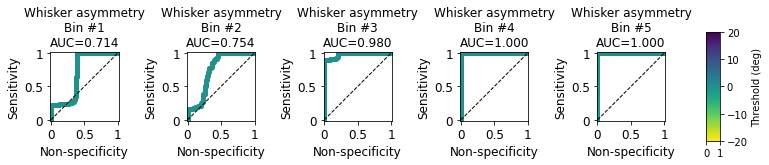

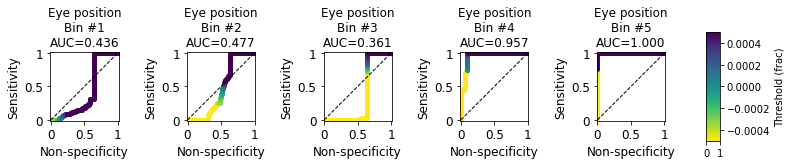

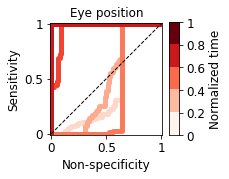

In [11]:
titles = dict(asym="Whisker asymmetry",
              eye="Eye position")
ranges = dict(asym=dict(vmin=-20, vmax=20),
              eye=dict(vmin=-0.0005, vmax=0.0005))
units = dict(asym="deg", eye="frac")
cmaps  = dict(asym=plt.get_cmap("Greens"),
              eye=plt.get_cmap("Reds"))

for datatype in ("asym", "eye"):
    fig = plt.figure(figsize=(12,2))
    grid = GridSpec(1, 25)
    for time_bin in range(nbin):
        ax = fig.add_subplot(grid[:,time_bin*5:(time_bin+1)*5-2])
        roc = rocs[datatype][time_bin]
        roc.plot(ax, **ranges[datatype])
        ax.plot((0, 1), (0, 1), "k--", lw=1)
        ax.set_xlim(-0.01, 1.01)
        ax.set_ylim(-0.01, 1.01)
        ax.set_xticks((0, 0.5, 1))
        ax.set_xticklabels(("0", "0.5", "1"))
        ax.set_yticks((0, 0.5, 1))
        ax.set_yticklabels(("0", "0.5", "1"))
        ax.set_aspect(1.0)
        ax.set_xlabel("Non-specificity", fontsize=labelsize)
        ax.set_ylabel("Sensitivity", fontsize=labelsize)
        ax.set_title(f"{titles[datatype]}\nBin #{time_bin+1}\nAUC={roc.AUC:.3f}")
        ax.tick_params(labelsize=labelsize)
    cb = fig.add_subplot(grid[:,24])
    bounds = (ranges[datatype]["vmin"], ranges[datatype]["vmax"])
    bar = np.linspace(*bounds,
                      num=100, endpoint=True).reshape((-1,1))
    cb.imshow(bar, extent=(0, 1,)+bounds, 
              aspect="auto", interpolation="none", **ranges[datatype])
    cb.yaxis.set_label_position("right")
    cb.yaxis.tick_right()
    cb.set_ylabel(f"Threshold ({units[datatype]})")
    plt.subplots_adjust(wspace=1)
    plt.show()

    fig = plt.figure(figsize=(3, 2.5))
    grid = GridSpec(20, 25)
    ax  = fig.add_subplot(grid[:,:20])
    for time_bin in range(nbin):
        roc = rocs[datatype][time_bin]
        ax.plot(roc.nonspecific, roc.sensitivity, "-", lw=5, 
                color=cmaps[datatype](0.15+0.15*time_bin)[:3])
    ax.plot((0, 1), (0, 1), "k--", lw=1)
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    ax.set_xticks((0, 0.5, 1))
    ax.set_xticklabels(("0", "0.5", "1"))
    ax.set_yticks((0, 0.5, 1))
    ax.set_yticklabels(("0", "0.5", "1"))
    ax.set_aspect(1.0)
    ax.set_xlabel("Non-specificity", fontsize=labelsize)
    ax.set_ylabel("Sensitivity", fontsize=labelsize)
    ax.set_title(titles[datatype])
    ax.tick_params(labelsize=labelsize)
    
    cb  = fig.add_subplot(grid[1:19,21:23])
    bar = np.arange(nbin)[::-1].reshape((-1,1))*0.15 + 0.15
    cb.imshow(bar, extent=(0, 1, 0, 1), 
              aspect="auto", interpolation="none",
              cmap=cmaps[datatype])
    cb.yaxis.set_label_position("right")
    cb.yaxis.tick_right()
    cb.set_yticks((0, 0.2, 0.4, 0.6, 0.8, 1))
    cb.set_yticklabels(("0", "0.2", "0.4", "0.6", "0.8", "1"))
    cb.set_ylabel("Normalized time", fontsize=labelsize)
    cb.tick_params(bottom=False, labelbottom=False, labelsize=labelsize)
    plt.subplots_adjust(left=.2, bottom=.2, right=.85, top=.9)
    savefig(fig, f"ROC-curves/{datatype}-individual")
    plt.show()

### Generalize for all sessions

In [12]:
class TurnBasedData(namedtuple("_TurnBased", ("left", "right", "metadata"))):
    @classmethod
    def from_dict(cls, D, metadata={}):
        return cls(D["left"], D["right"], metadata)

class SessionData(namedtuple("_SessionData", ("subject", "session", "asym", "eye"))):
    datatypes_  = ("asym", "eye")
    directions_ = ("left", "right")
    
    @classmethod
    def from_dict(cls, subject, session, D):
        return cls(subject, session, D["asym"], D["eye"])

class BinnedDataPoints(SessionData):
    """data points being binned based on its normalized time points."""
    @classmethod
    def load(cls, trials, subject, session,
             nbin=5, pattern="AtEnd <Backward> {direction}"):
        
        in_session = [trial for trial in trials if (trial.subject == subject and trial.session == session)]
        if len(in_session) == 0:
            raise ValueError(f"no matched trials found for: {subject}, {session}")
        
        # get traces during Backward
        points = dict(asym={}, eye={}, saccade={})
        for direction in cls.directions_:
            _pattern = pattern.format(direction=in_camel(direction.lower()))
            points["asym"][direction.lower()]    = collect(in_session, setpoint_asymmetry_from_trial, 
                                                           pattern=_pattern)
            points["eye"][direction.lower()]     = collect(in_session, eye_position_from_trial, 
                                                           pattern=_pattern)
            
        # bin epoch time to `nbin`
        points_tbinned = dict()
        for datatype, directions in points.items():
            points_tbinned[datatype] = []
            for i in range(nbin):
                points_tbinned[datatype].append({})
            for direction, traces in directions.items():
                for i, values in enumerate(bin_traces(traces, nbin=nbin, concat=True)):
                    points_tbinned[datatype][i][direction] = values
        
        # format to TurnBasedData
        for datatype in cls.datatypes_:
            for i, time_bin in enumerate(points_tbinned[datatype]):
                points_tbinned[datatype][i] = TurnBasedData.from_dict(time_bin)
                    
        return cls.from_dict(subject, session, points_tbinned)

    def shuffled(self):
        ret = {}
        for datatype in self.datatypes_:
            ret[datatype] = []
            # shuffle values for each bin
            for binned in getattr(self, datatype):
                nleft  = binned.left.size
                merged = np.concatenate([binned.left, binned.right], axis=0)
                np.random.shuffle(merged)
                ret[datatype].append(TurnBasedData.from_dict(dict(left=merged[:nleft], right=merged[nleft:])))
        return self.from_dict(self.subject, self.session, ret)
    
    @property
    def ROC(self):
        ret = {}
        for datatype in self.datatypes_:
            ret[datatype] = []
            for time_bin in getattr(self, datatype):
                ret[datatype].append(ROC.compute(time_bin.left, time_bin.right))
        return SessionData.from_dict(self.subject, self.session, ret)

In [13]:
points = []
points_rand = []
aucs      = dict(asym=[], eye=[])
aucs_rand = dict(asym=[], eye=[])
np.random.seed(539167)

for subject, session in set((trial.subject, trial.session) for trial in trials):
    try:
        _P  = BinnedDataPoints.load(trials, subject, session)
        _Pr = _P.shuffled()
        _R  = _P.ROC
        _Rr = _Pr.ROC
        
        for fld in SessionData.datatypes_:
            aucs[fld].append(np.array([roc.AUC for roc in getattr(_R, fld)]))
            aucs_rand[fld].append(np.array([roc.AUC for roc in getattr(_Rr, fld)]))
            
        points.append(_P)
        points_rand.append(_Pr)
    except NoEpochFoundError as e:
        print(f"***in {subject}, {session}: {e}")
for key in aucs.keys():
    aucs[key]      = np.stack(aucs[key], axis=-1)
    aucs_rand[key] = np.stack(aucs_rand[key], axis=-1)

***in MLA005757, session2019-07-18-001: no epoch found from 5 trials (eye_position_from_trial, AtEnd <Backward> Left)
***in MLA005757, session2019-07-16-001: no epoch found from 5 trials (setpoint_asymmetry_from_trial, AtEnd <Backward> Right)
***in MLA007519, session2019-10-01-001: no epoch found from 5 trials (eye_position_from_trial, AtEnd <Backward> Left)
***in MLA007519, session2019-10-02-001: no epoch found from 4 trials (eye_position_from_trial, AtEnd <Backward> Left)
***in MLA007519, session2019-09-29-001: no epoch found from 3 trials (eye_position_from_trial, AtEnd <Backward> Left)
***in MLA007518, session2019-10-07-001: no epoch found from 4 trials (setpoint_asymmetry_from_trial, AtEnd <Backward> Right)
***in MLA007519, session2019-09-30-001: no epoch found from 3 trials (setpoint_asymmetry_from_trial, AtEnd <Backward> Right)
***in MLA007518, session2019-10-04-001: no epoch found from 5 trials (eye_position_from_trial, AtEnd <Backward> Left)


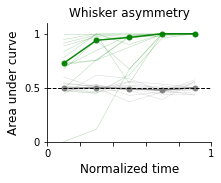

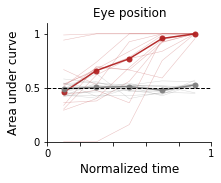

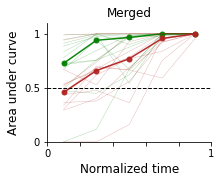

In [14]:
titles = dict(asym="Whisker asymmetry",
              eye="Eye position")
linecolors = dict(asym="g",
                  eye="firebrick")
x = np.arange(nbin)*0.2 + 0.1
xticks = (0, 0.2, 0.4, 0.6, 0.8, 1)
xticklabels = ("0", "", "", "", "", "1")
marker = 12

for datatype in SessionData.datatypes_:
    fig = plt.figure(figsize=(3, 2.5))
    plt.plot(x, aucs[datatype], "-", color=linecolors[datatype], lw=.5, alpha=.3)
    plt.plot(x, np.median(aucs[datatype], -1), ".-", color=linecolors[datatype], lw=1.5, alpha=.95, 
             ms=marker, mec='none')
    plt.plot(x, aucs_rand[datatype], "-", color="gray", lw=.5, alpha=.3)
    plt.plot(x, np.median(aucs_rand[datatype],-1), ".-", color="gray", lw=1.5, alpha=.95, 
             ms=marker, mec='none')
    plt.hlines(0.5, 0, 1, color="k", linestyle="--", linewidth=1)

    plt.xlim(0, 1)
    plt.ylim(0, 1.1)
    plt.xticks(xticks, xticklabels)
    plt.yticks((0, 0.5, 1), ("0", "0.5", "1"))
    for side in ("top", "right"):
        plt.gca().spines[side].set_visible(False)
    plt.xlabel("Normalized time", fontsize=labelsize)
    plt.ylabel("Area under curve", fontsize=labelsize)
    plt.title(titles[datatype], fontsize=labelsize)
    plt.subplots_adjust(left=.22, right=.98, bottom=.22)
    savefig(fig, f"AUC-values/{datatype}-allsessions")
    plt.show()
    
# merged
fig = plt.figure(figsize=(3, 2.5))
for datatype in SessionData.datatypes_:
    plt.plot(x, aucs[datatype], "-", color=linecolors[datatype], lw=.5, alpha=.3)
    plt.plot(x, np.median(aucs[datatype], -1), ".-", color=linecolors[datatype], lw=1.5, alpha=.95,
             ms=marker, mec='none')
plt.hlines(0.5, 0, 1, color="k", linestyle="--", linewidth=1)

plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.xticks(xticks, xticklabels)
plt.yticks((0, 0.5, 1), ("0", "0.5", "1"))
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.xlabel("Normalized time", fontsize=labelsize)
plt.ylabel("Area under curve", fontsize=labelsize)
plt.title("Merged", fontsize=labelsize)
plt.subplots_adjust(left=.22, right=.98, bottom=.22)
savefig(fig, f"AUC-values/merged-allsessions")
plt.show()

In [15]:
combis = ((0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4))
test   = stats.mannwhitneyu

print("# p-values\n")
for statstype, data_used, rand_used in (("AUC", aucs, aucs_rand),):
    for datatype in SessionData.datatypes_:
        print(f"## {titles[datatype]}, {statstype}")
        print("")
        print("### data vs per-bin shuffled")
        print("")
        pvals = [test(data_used[datatype][i], rand_used[datatype][i]).pvalue for i in range(5)]
        for i, pval in enumerate(pvals):
            print(f"- bin#{i+1}: p={pval}{psign(pval)}")
        print("")
        print("### paired comparison")
        print("")
        for p1, p2 in combis:
            pval = test(data_used[datatype][p1], data_used[datatype][p2]).pvalue * len(combis)
            print(f"- bin#{p1+1} vs bin#{p2+1}: p={pval}{psign(pval)}")
        print("")
    
    print(f"## {statstype}, whisker asymmetry vs eye position")
    print("")
    pvals = [test(data_used["asym"][i], data_used["eye"][i]).pvalue for i in range(5)]
    for i, pval in enumerate(pvals):
        print(f"- bin#{i+1}: p={pval}{psign(pval)}")
    print("")

# p-values

## Whisker asymmetry, AUC

### data vs per-bin shuffled

- bin#1: p=0.006568801831243719**
- bin#2: p=0.002916591157675532**
- bin#3: p=3.259192282860724e-05***
- bin#4: p=1.0881572934871498e-05***
- bin#5: p=4.151388909112204e-06***

### paired comparison

- bin#1 vs bin#2: p=1.0562961656964394, NS
- bin#1 vs bin#3: p=0.903667986647609, NS
- bin#1 vs bin#4: p=0.00067239544019378***
- bin#1 vs bin#5: p=0.00015256330144079188***
- bin#2 vs bin#3: p=8.773141934901375, NS
- bin#2 vs bin#4: p=0.038716557807790625*
- bin#2 vs bin#5: p=0.0015965699992383435**
- bin#3 vs bin#4: p=0.013761755251058645*
- bin#3 vs bin#5: p=0.0005138917930562222***
- bin#4 vs bin#5: p=0.3734909329710342, NS

## Eye position, AUC

### data vs per-bin shuffled

- bin#1: p=0.6444123337698114, NS
- bin#2: p=0.11183133142870988, NS
- bin#3: p=0.002916591157675532**
- bin#4: p=1.5427428853582637e-05***
- bin#5: p=5.757321672787589e-06***

### paired comparison

- bin#1 vs bin#2: p=1.0610789881370306, NS
- 